In [1]:
# ---imports---
import sys
import os
import random
sys.path.append('.')
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning.pytorch as pl
import rasterio

from models.DeepLabV3_LSTM_Lightning_ESRI_UrbanRural import DeepLabV3_LSTM_Lightning_ESRI_UrbanRural

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches as mpatches

### Cross-validation fold setup

In [2]:
fold_1 = ['Algeria', 'Niger', 'Mauritania', 'Mozambique', 'CentralAfricanRepublic', 'Zimbabwe', 'Guinea', 'Malawi', 'Togo']
fold_2 = ['DemocraticRepublicoftheCongo', 'Angola', 'Egypt', 'Zambia', 'Madagascar', 'Congo', 'Ghana', 'Eritrea', 'Guinea-Bissau']
fold_3 = ['Sudan', 'Mali', 'UnitedRepublicofTanzania', 'Morocco', 'Botswana', 'CotedIvoire', 'Uganda', 'Benin', 'Lesotho']
fold_4 = ['Libya', 'SouthAfrica', 'Nigeria', 'SouthSudan', 'Kenya', 'BurkinaFaso', 'Senegal', 'Liberia']
fold_5 = ['Chad', 'Ethiopia', 'Namibia', 'Somalia', 'Cameroon', 'Gabon', 'Tunisia', 'SierraLeone', 'Burundi']

training_folds =  fold_1 + fold_2 + fold_3
val_fold = fold_4
test_fold = fold_5

### Codices

In [3]:
# --- Class Codices ---

# -ESRI LULC 2020 (9 classes): class codec
# 1(->0): Water
# 2(->1): Tree
# 4(->2): Flooded Vegetation
# 5(->3): Crops
# 7(->6): Built Area
# 8(->4): Bare Ground
# 9(->(-1)): Snow / Ice
# 10(->(-1)): Clouds
# 11(->5): Rangeland
# 12(->(-1)): Missing
esri_classes = [1, 2, 4, 5, 7, 8, 9, 10, 11, 12]
labels = [0, 1, 2, 3, 6, 4, -1, -1, 5, -1]

esri_class_to_index_map = np.zeros(max(esri_classes) + 1, dtype='int64')
esri_class_to_index_map[esri_classes] = labels


# ---GHS-SMOD 2020 (8 classes): class codec---
# 30(->7): URBAN CENTRE GRID CELL
# 23(->7): DENSE URBAN CLUSTER GRID CELL
# 22(->7): SEMI-DENSE URBAN CLUSTER GRID CELL
# 21(->7): SUBURBAN OR PERI-URBAN GRID CELL
# 13(->6): RURAL CLUSTER GRID CELL
# 12(->6): LOW DENSITY RURAL GRID CELL
# 11(->6): VERY LOW DENSITY RURAL GRID CELL
# 10(->6): WATER GRID CELL
# NoData [-Inf] -> 7
smod_classes = [10, 11, 12, 13, 21, 22, 23, 30]
labels = [6, 6, 6, 6, 7, 7, 7, 7]

smod_class_to_index_map = np.zeros(max(smod_classes) + 1, dtype='int64')
smod_class_to_index_map[smod_classes] = labels

### Preprocessing

In [4]:
def preprocess_labels(smod, esri_labels):
    # prepare smod 
    smod[np.isinf(smod)] = 10
    smod = smod.astype('int64')
            
    # prepare esri
    esri_inf_mask = np.isinf(esri_labels) 
    esri_labels[esri_inf_mask] = -1
    esri_labels = esri_labels.astype('int64')
    
    # label preprocessing: remap to standard class indices using class codec
    smod = smod_class_to_index_map[smod]
    esri_labels = esri_class_to_index_map[esri_labels]
    np.putmask(esri_labels, esri_labels == 6, smod)
    
    return esri_labels

def preprocess_input(image):
    # input preprocessing: normalize input bands to range (0.0, 1.0), mask missing data
    image[0:6] = (image[0:6] - 1) / (65455 - 1)  # bands SR_B2 to SR_B7: BGR, NIR, SWIR1, SWIR2 (1, 65455)
    nl_clipped = np.clip(image[6], a_min=-1.5, a_max=193565)
    image[6] = (nl_clipped + 1.5) / (193565 + 1.5)   # band avg_rad: VIIRS (-1.5, 193565)
            
    # set missing data to zero
    inf_mask = np.isinf(image[0])
    image[0:6, inf_mask] = 0
    image[1, np.isinf(image[1])] = 0
    image[2, np.isinf(image[2])] = 0

In [5]:
def get_patches(image_timeseries):
    '''split each (1000,1000)-supertile into 16*(250,250)-subtiles'''
    
    # arrays to hold the data
    image_seq = np.zeros((5, 7, 1000, 1000), dtype="float32")

    # read input from y1-y5
    for i, image_year_i in enumerate(image_timeseries):
        image_seq[i] = image_year_i[:7]
        preprocess_input(image_seq[i])

    # loop through each subtile
    for sub_tile_idx in range(36):
            
        # calculate offset
        r = (sub_tile_idx // 6) * 150
        c = (sub_tile_idx % 6) * 150

        # handle input data (time_seq, channels, height, width) 
        sub_tile_seq = image_seq[:, :, r:r+250, c:c+250]

        yield (sub_tile_seq, _)

### Load tile

In [6]:
# load tile to predict on
# SierraLeone, Angola, Egypt, Madagascar
# report-sierra leone: 311, 523, angola: 8610, egypt:915, madagascar: 3458
country = 'SierraLeone'
tile = 'tile_523'

im_path1 = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/2016/{country}/{tile}.tif_2016'
im_path2 = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/2017/{country}/{tile}.tif_2017'
im_path3 = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/2018/{country}/{tile}.tif_2018'
im_path4 = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/2019/{country}/{tile}.tif_2019'
im_path5 = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/2020/{country}/{tile}.tif_2020'

src = [rasterio.open(im_path1).read(), rasterio.open(im_path2).read(), 
       rasterio.open(im_path3).read(), rasterio.open(im_path4).read(), rasterio.open(im_path5).read()]

# iterator over subtiles
im_iterator = get_patches(src)

# prepare target for visualization
smod = src[4][7]
smod[np.isinf(smod)] = 10
smod = smod.astype('int64')

esri_labels = src[4][9]
esri_labels[np.isinf(esri_labels)] = -1
esri_labels = esri_labels.astype('int64')

smod = smod_class_to_index_map[smod]
esri_labels = esri_class_to_index_map[esri_labels]
np.putmask(esri_labels, esri_labels == 6, smod)
np.putmask(esri_labels, esri_labels == -1, 5)  # for visualizing missing data

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


### Load Model

In [7]:
# load model from checkpoint
mimer = '/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/scripts_and_notebooks/job_scripts/'

# model 1
base_ckpt = mimer + "lightning_logs/deeplabv3_esri_urban_rural_12345/checkpoints/12345_epoch=19-step=126080-val_loss=0.440.ckpt"
ckpt = mimer + "/lightning_logs/version_1151224/checkpoints/12345_epoch=2-step=38304-val_loss=0.461.ckpt"

# model 3
'''base_ckpt = mimer + "/lightning_logs/deeplabv3_esri_urban_rural_34512/checkpoints/34512_epoch=19-step=106240-val_loss=0.369.ckpt"
ckpt = mimer + "/lightning_logs/version_1158393/checkpoints/34512_epoch=2-step=32400-val_loss=0.402.ckpt"'''

lightning_model = DeepLabV3_LSTM_Lightning_ESRI_UrbanRural.load_from_checkpoint(ckpt, current_ckpt=base_ckpt, training_folds=training_folds, validation_fold=fold_4)

### Inference

In [10]:
# predict on selected tile, split in its subtiles
predictions = []
prediction_probs = []
for idx, img in enumerate(im_iterator):
    
    in_data, labels = img
    in_data = torch.tensor(in_data)
    in_data = torch.unsqueeze(in_data, 0)

    lightning_model.eval()

    with torch.no_grad():
        outputs = lightning_model(in_data)
        
        class_probs = F.softmax(outputs, dim=1)
        prediction_probs.append(class_probs)
        class_predictions = torch.argmax(input=class_probs, dim=1)
        
        predictions.append(class_predictions)

In [11]:
# assemble sub-tile predictions into supertile
predictions_supertile = np.zeros((5, 1000, 1000))
for sub_tile_idx in range(36):

    sub_tile = predictions[sub_tile_idx].squeeze()
    print(sub_tile.shape)
    
    # calculate offset
    r = (sub_tile_idx // 6) * 150
    c = (sub_tile_idx % 6) * 150
    
    # adjust row margins
    if r == 0:
        row_start_margin = 0
        row_end_margin = 200
    elif r == 750:
        row_start_margin = 50
        row_end_margin = 250
    else:
        row_start_margin = 50
        row_end_margin = 200
    
    # adjust col margins
    if c == 0:
        col_start_margin = 0
        col_end_margin = 200
    elif c == 750:
        col_start_margin = 50
        col_end_margin = 250
    else:
        col_start_margin = 50
        col_end_margin = 200
    
    # put sub-tile in correct position
    cut_subtile = sub_tile[:, row_start_margin:row_end_margin, col_start_margin:col_end_margin]
    predictions_supertile[:, r+row_start_margin: r+row_end_margin, c+col_start_margin : c+col_end_margin] = cut_subtile

torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])
torch.Size([5, 250, 250])


### Plot

In [14]:
colormap_classes_rgb = np.array([[0, 100, 200], [0, 100, 0], [0, 207, 117], 
                                 [240, 150, 255], [180, 180, 180], [255, 187, 34], 
                                 [255, 0,0], [80,0,0]]) / 255  # RGB values for each class, normalized to (0, 1)

class_labels = ['c1:Water', 'c2:Tree', 'c3:Flooded Vegetation', 
                'c4:Crops', 'c5:Bare Ground', 'c6:Rangeland', 
                'c7:Rural', 'c8: Urban']

cmap_classes = ListedColormap(colormap_classes_rgb, name='ESRI_WorldCover_2020_class_cmap', N=8)

#### Prediction

In [15]:
predictions_supertile.shape

(5, 1000, 1000)

In [16]:
predictions[0].shape

torch.Size([5, 250, 250])

(-0.5, 999.5, 999.5, -0.5)

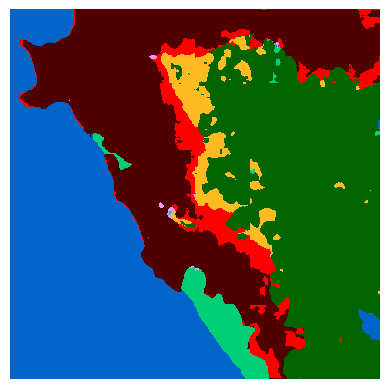

In [24]:
# predictions_supertile[i] shows year i in sequence
plt.imshow(predictions_supertile[4], cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')
plt.axis('off')
#plt.title('prediction')

#### Target

Text(0.5, 1.0, 'target')

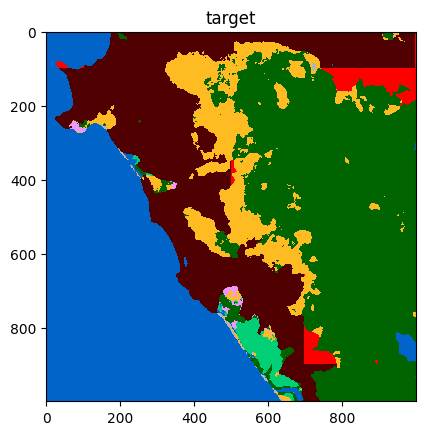

In [18]:
plt.imshow(esri_labels, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')
plt.title('target')

#### Prediction vs Target

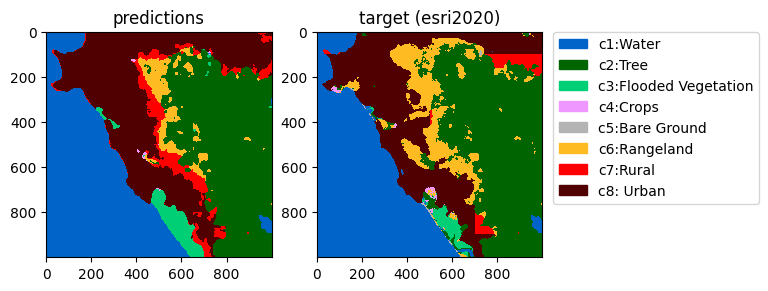

In [19]:
# plot result
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('predictions')
ax1.imshow(predictions_supertile[4], cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')

ax2.set_title('target (esri2020)')
ax2.imshow(esri_labels, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest',)

patches = [mpatches.Patch(color=colormap_classes_rgb[i], label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.0)